# Supplementary Material

> **"Background-dependent selection of genetic variation in heterogeneous populations"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Supplementary Figures S9 and S10

This IPython notebook is provided for reproduction of Figures S9 and S10 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [1]:
# load external dependencies
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from matplotlib.ticker import FormatStrFormatter,MaxNLocator
%matplotlib inline

import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation
import brewer2mpl
from scipy import stats

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

# load internal dependencies
import colors,plot,model,utils,config

%load_ext autoreload
%autoreload 2

# absolute file path for data directory
from paths import *

In [2]:
# load data
pheno_df = utils.load_data(dir_data+'pheno/populations/pheno_populations_norm.pickle')

# normalise by the ancestral population
def norm(df):
    df['growth_rate'] = df['growth_rate'] - df[df.group=='ancestral'].growth_rate.mean()
    return df

pheno_df = pheno_df.groupby(['selection','environment'], as_index=False).apply(norm)

# filter out strains used for spatial control
pheno_df = pheno_df[(pheno_df.group == 'parents')|\
                    (pheno_df.group == 'constructs')|\
                    ((pheno_df.group == 'evolved')&(pheno_df.background == 'WAxNA')&\
                     (pheno_df.cross == 'F12')&(pheno_df.cross_rep == 2)&\
                     (pheno_df.selection == 'HU')&(pheno_df.selection_rep == 2)&\
                     (pheno_df.isolate == 2)&(pheno_df.genotype_long == 'rnr2*/RNR2'))|\
                    ((pheno_df.group == 'evolved')&(pheno_df.background == 'WAxNA')&\
                     (pheno_df.cross == 'F12')&(pheno_df.cross_rep == 2)&\
                     (pheno_df.selection == 'RM')&(pheno_df.selection_rep == 2)&\
                     (pheno_df.isolate == 6)&(pheno_df.genotype_long == 'tor1*/TOR1'))]

pheno_df = pheno_df.replace('WAxNA','WA/NA')

# duplicate shared controls by candidate gene
groups_1 = pheno_df.groupby(['selection','environment','gene','background'])
for (ii,((env_evo, env_test, gene, population),g1)) in enumerate(groups_1):
    
    if gene!='':
        df = groups_1.get_group((env_evo, env_test,'', population))        
        df = df.replace([env_evo, env_test,'', population],[env_evo, env_test,gene, population])
        
        pheno_df = pheno_df.append(df)

pheno_df = pheno_df[pheno_df.gene != '']
pheno_df = pheno_df.reset_index(drop=True)

# # filter out measurement replicates with >5% measurement error
# pheno_df['pct'] = pheno_df.groupby(['selection','environment','gene','background','genotype_long'])['growth_rate']\
# .apply(lambda x: (x-x.mean())/float(x.mean()))
# pheno_df = pheno_df[abs(pheno_df['pct'])<0.05]

pheno_df.head()  # show dataframe header to stdout

,selection,environment,run,index,plate,row,column,id,id_plate,group,...,assignment,isolate,gene,genotype_short,genotype_long,amino_acids,mating,auxotrophy,doubling_time,growth_rate
0,RM,RM,1,466,0,9,34,P10_C9,10,constructs,...,,,YNR066C,,ynr066cΔ,,MATa,,0.497132,-0.245126
1,RM,RM,1,470,0,9,38,P10_C10,10,constructs,...,,,YNR066C,,ynr066cΔ,,MATa,,-0.182682,0.181352
2,RM,RM,1,474,0,9,42,P10_C11,10,constructs,...,,,YNR066C,,ynr066cΔ WA/YNR066C NA,,MATa/α,,0.161159,-0.059334
3,RM,RM,1,478,0,9,46,P10_C12,10,constructs,...,,,YNR066C,,YNR066C WA/ynr066cΔ NA,,MATa/α,,0.237700,-0.105543
4,RM,RM,1,562,0,11,34,P10_C9,10,constructs,...,,,YNR066C,,ynr066cΔ,,MATa,,0.317800,-0.151348


In [3]:
from scipy import stats 

stattest=[]

param='growth_rate'

for ((env_evo,env_test,gene),geeg) in pheno_df.groupby(['selection','environment','gene']):
    for ((background,genotype),gbg) in geeg.groupby(['background','genotype_long']):
        if (background,genotype) in config.construct_tests[gene]:
            wt=config.construct_tests[gene][(background,genotype)]#
            mut=(background,genotype)
            wt_data = geeg.groupby(['background','genotype_long']).get_group(wt)[param]
            mut_data = geeg.groupby(['background','genotype_long']).get_group(mut)[param]
            wt_data = wt_data.dropna().tolist()
            mut_data = mut_data.dropna().tolist()
            x_min=min(wt_data+mut_data)
            x_max=max(wt_data+mut_data)
            z_stat,p_val = stats.ranksums(wt_data,mut_data)
            stattest.append([env_evo,env_test,gene,
                             wt,mut,x_min,x_max,
                             z_stat,p_val,utils.stars(p_val)])

stattest = pd.DataFrame(stattest,columns=('selection','environment','gene',
                                          'wt','mut','min','max',
                                          'z_stat','p_val','stars'))

stattest_to_file = stattest.sort_values(['gene','selection', 'environment','p_val'])
stattest_to_file['wt'] = pd.Series(','.join(k) for k in stattest_to_file['wt'])
stattest_to_file['mut'] = pd.Series(','.join(k) for k in stattest_to_file['mut'])

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

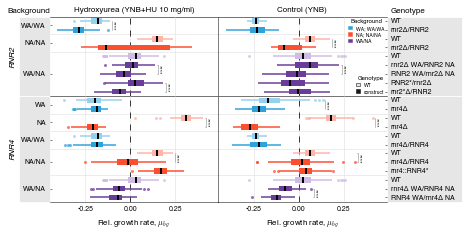

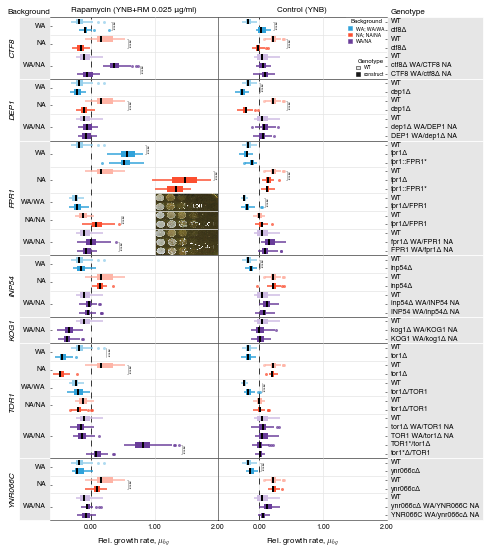

In [4]:
param = 'growth_rate'

shape = pd.DataFrame({k: 
 pd.pivot_table(x, values='growth_rate', columns=['background','genotype_long']).shape
 for k,x in pheno_df.groupby(['selection','environment','gene'])
})

for (ii, ((env_evo), gph1)) in enumerate(pheno_df.groupby(['selection'])):

    # remove NaNs
    gph1 = gph1[np.isfinite(gph1[param])]
    
    nrows=len(gph1.groupby(['background','gene','genotype_long']))
    ncols=len(gph1.groupby(['environment']))
            
    height, width = np.array([nrows*0.125, ncols*3], dtype=float)
    
    fig = plt.figure(figsize=(width, height), dpi=300)
    
    fig.subplots_adjust(left=0.07,bottom=0.01,right=0.85,top=0.99)

    grid = gridspec.GridSpec(1, 2, hspace=0., wspace=0.)
    
    gs = {}
        
    for (jj, ((env_test), gph2)) in enumerate(gph1.groupby(['environment'])):
        
        nrows = len(gph2['gene'].unique())
        ncols = 1
        height_ratios = shape[env_evo,env_test].values.squeeze()
        gs[env_test] = gridspec.GridSpecFromSubplotSpec(nrows, ncols, height_ratios=height_ratios, 
                                                        subplot_spec=grid[0,jj], hspace=0., wspace=0.)
    
        axes = {}
        
        for (kk, ((gene), gph3)) in enumerate(gph2.groupby('gene')):
                        
            gph3.loc[:,'rank_background'] = gph3['background'].map(config.construct_background['position'])
            gph3.loc[:,'rank_genotype'] = gph3['genotype_long'].map(config.construct_genotype[env_evo][gene])
            gph3.sort_values(['rank_background','rank_genotype'], 
                             ascending=[False,False], inplace=True)
      
            if kk == 0:
                axes[env_test] = plt.subplot(gs[env_test][kk])
                ax1 = axes[env_test]
                ax1.set_title(config.dict_environment['long_label'][env_test], fontsize=8)
            else:
                ax1 = plt.subplot(gs[env_test][kk], sharex=axes[env_test])
            
            gph3 = gph3.set_index(['background','genotype_long'], append=True)[param]\
            .unstack(['background','genotype_long'])
            
            # boxplot
            bp = gph3.plot(ax=ax1, kind='box', widths=0.65, vert=False, return_type='dict',
                           labels=gph3.columns.get_level_values('background'))
            
            colors = [config.construct_background['color']['wt'][b] if g=='WT' \
                      else config.construct_background['color']['mut'][b] \
                      for b,g in zip(gph3.columns.get_level_values('background'),\
                                     gph3.columns.get_level_values('genotype_long'))]
            plot.boxplot_custom(bp, ax1, colors=colors, hatches=['']*30)
            
            for ll, x in enumerate(gph3.columns):
                
                if x in config.construct_tests[gene]:
                    
                    wt_data = gph3[config.construct_tests[gene][x]].dropna()
                    mut_data = gph3[x].dropna()
                    z_stat, p_val = stats.ranksums(wt_data,mut_data)
                                        
                    if p_val < 0.0001:
                    
                        x_min = min(wt_data.min(),mut_data.min())
                        x_max = max(wt_data.max(),mut_data.max())
                             
                        ax1.annotate('', xy=(x_max, ll+1), xycoords='data',
                                     xytext=(x_max, ll+2), textcoords='data',
                                     arrowprops=dict(arrowstyle="-", ec='#aaaaaa', linewidth=.75,
                                                     connectionstyle="bar,fraction=-0.3"))
                        ax1.annotate(utils.stars(p_val), 
                                     xy=((x_max+0.02 if env_evo=='HU' else x_max+0.04), ll+1.5), xycoords='data',
                                     ha='center', va='center', fontsize=6, rotation=270)
                        
            if jj==0:
                ax1.annotate(gene, 
                             xy=(-0.2, 0.5), xycoords=("axes fraction", "axes fraction"),
                             ha='right', va='center', annotation_clip=False, rotation=90, 
                             fontsize=8, fontstyle='italic')

            # reset ticks
            ax1.set_yticks([])
            ax1.set_yticklabels([])
            
            ax1.set_axisbelow(False)
            
            ### vertical ###
            ax1.xaxis.grid(ls="-", lw=.75, color="0.9", zorder=0)
            ax1.axvline(x=0., color='k', ls="--", lw=.75, zorder=3)
            
            ### horizontal ###
            
            ## background
            ystart, yend, ylabels = plot.set_custom_labels(gph3.columns, 0)
            
            # grid
            ygrid=[yst+1.5 for yst in list(set(ystart.values()))]
            [ax1.axhline(g, lw=.75, ls="-", color="0.9", zorder=2) for g in ygrid]
            
            # labels
            if jj==0:
                # tick labels
                ax1.set_yticks([y+1 for y in ylabels.values()], minor=True)
                ax1.set_yticklabels(ylabels.keys(), minor=True)
                ax1.get_yaxis().tick_left()
                if kk==0:
                    # axis label
                    ax1.set_ylabel('Background', transform=ax1.transAxes, rotation=0)
                    ax1.yaxis.set_label_coords(-0.125, 1.025)
            
            ## genotype
            # labels
            if jj==1:
                # tick labels
                ylabels = gph3.columns.get_level_values('genotype_long')
                ax1.set_yticks(np.arange(1, len(ylabels)+1), minor=True)
                ax1.set_yticklabels(['/'.join(y) if isinstance(y, tuple) else y for y in ylabels], minor=True)
                ax1.get_yaxis().tick_right()
                if kk==0:
                    # axis label
                    ax1.set_ylabel('Genotype', transform=ax1.transAxes, rotation=0)
                    ax1.yaxis.set_label_coords(1.125, 1.025)
            
            # set axes labels
            ax1.set_xlabel(r'Rel. growth rate, $\mu_{bg}$', fontsize=10)
            
            if jj==1 and kk==0:
                wa_artist = patches.Rectangle((0,0), width=1, height=1, 
                                              color=config.construct_background['color']['mut']['WA'])
                na_artist = patches.Rectangle((0,0), width=1, height=1, 
                                              color=config.construct_background['color']['mut']['NA'])
                wana_artist = patches.Rectangle((0,0), width=1, height=1, 
                                                color=config.construct_background['color']['mut']['WA/NA'])

                leg1 = ax1.legend([wa_artist,na_artist,wana_artist], 
                                  ['WA; WA/WA','NA; NA/NA','WA/NA'], 
                                  ncol=1, loc='upper right',
                                  borderaxespad=0, handlelength=0.75, 
                                  prop={'size':5}, title='Background', 
                                  labelspacing=.32)

                wt_artist = patches.Rectangle((0,0), width=1, height=1, facecolor='0.9', edgecolor='k')
                construct_artist = patches.Rectangle((0,0), width=1, height=1, facecolor='0.1', edgecolor='k')

                leg2 = ax1.legend([wt_artist,construct_artist], 
                                  ['WT','construct'], 
                                  ncol=1, loc='lower right',
                                  borderaxespad=0, handlelength=0.75, 
                                  prop={'size':5}, title='Genotype', 
                                  labelspacing=.32)
                        
                ax1.add_artist(leg1)
        
                for leg in [leg1,leg2]:
                    plt.setp(leg.get_title(),fontsize=6)
                    leg.set_zorder(2)
                    leg.get_frame().set_edgecolor('none')
                    leg.get_frame().set_facecolor('w')
                    
            if env_evo=='RM' and env_test=='RM' and gene=='FPR1':
                transform = transforms.blended_transform_factory(ax1.transAxes, ax1.transData)
                x0, x1, y0, y1 = (1.0, 2.0, .5, 7.5)
                im = ax1.imshow(plt.imread(dir_supp+'figures/supp_figure_pheno_constructs/FPR1_LOH_inset.png'),
                                aspect='auto', extent=(x0, x1, y0, y1), transform=transform, zorder=1)
            
            transform = transforms.blended_transform_factory(ax1.transAxes, ax1.transAxes)
            if env_evo=='HU':
                ax1.set_xlim(-0.45,0.49)
                ax1.xaxis.set_major_locator( MaxNLocator(nbins = 4) )
                ax1.xaxis.set_minor_locator( MaxNLocator(nbins = 4) )
                ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                if env_test=='HU':
                    ax1.spines['left'].set_visible(False)
                    ax1.spines['right'].set_visible(True)
                    patch = patches.Rectangle((-.25,0), width=.05, height=1,
                                              linewidth=.75, facecolor='0.9', edgecolor='w', 
                                              transform=transform, zorder=0)
                    patch = patches.Rectangle((-.18,0), width=.18, height=1,
                                              linewidth=.75, facecolor='0.9', edgecolor='w', 
                                              transform=transform, zorder=0)
                if env_test=='YNB':
                    ax1.spines['left'].set_visible(True)
                    ax1.spines['right'].set_visible(False)
                    patch = patches.Rectangle((1,0), width=.45, height=1,
                                              linewidth=.75, facecolor='0.9', edgecolor='w', 
                                              transform=transform, zorder=0)
            elif env_evo=='RM':
                ax1.set_xlim(-0.65,2)
                ax1.xaxis.set_major_locator( MaxNLocator(nbins = 3) )
                ax1.xaxis.set_minor_locator( MaxNLocator(nbins = 3) )
                ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                if env_test=='RM':
                    ax1.spines['left'].set_visible(False)
                    ax1.spines['right'].set_visible(True)
                    patch = patches.Rectangle((-.18,0), width=.18, height=1,
                                              linewidth=.75, facecolor='0.9', edgecolor='w',  
                                              transform=transform, zorder=0)
                if env_test=='YNB':
                    ax1.spines['left'].set_visible(True)
                    ax1.spines['right'].set_visible(False)
                    patch = patches.Rectangle((1,0), width=.575, height=1,
                                              linewidth=.75, facecolor='0.9', edgecolor='w',  
                                              transform=transform, zorder=0)
                    patch.set_clip_on(False)
            ax1.add_patch(patch)
            patch.set_clip_on(False)

        # tweak axes
        for ax in fig.get_axes():
            ax.spines['top'].set_visible(True)
            ax.spines['bottom'].set_visible(True)
            
            ax.xaxis.label.set_size(8)
            ax.yaxis.label.set_size(8)
            ax.tick_params(axis='x', which='both', size=0, labelsize=7)
            ax.tick_params(axis='y', which='major', size=2, labelsize=7)
            ax.tick_params(axis='y', which='minor', size=2, labelsize=7)
            for sp in ax.spines.values():
                sp.set(color='k', linewidth=.5, linestyle='-')

    fig.savefig(dir_supp+'figures/supp_figure_pheno_constructs/supp_figure_pheno_constructs_%s.png' % env_evo, 
                dpi=300, bbox_inches='tight')
    fig.savefig(dir_supp+'figures/supp_figure_pheno_constructs/supp_figure_pheno_constructs_%s.svg' % env_evo, 
                dpi=300, bbox_inches='tight')
plt.show()